# Further Analysis for STAT3888 Group Project

### Importing Packages, Loading Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


biom_data = pd.read_csv("data/tech_biom.csv")
nutr_data = pd.read_csv("data/AHS11nutrient.csv")

### Selecting Response Variables and Confounders

In [4]:
# Select relevant cardiovascular variables 
response_vars = ["ABSPID", "BMISC", "HCHOLBC", "CHOLRESB", "CHOLNTR", "HDLCHREB", "LDLNTR",
                "LDLRESB", "DIASTOL", "SYSTOL", "HSUGBC"]
confounders = ["ADTOTSE", "SMKSTAT", "AGEC", "EXLWTBC", "SF2SA1QN", "SEX", "DIAHBRSK"]

cardio_data = biom_data[response_vars + confounders]

# Or as another option, selecting all the data variables
# cardio_data = biom_data[biom_data.columns[~biom_data.columns.str.endswith('MISS')]]

### Function to get the principal components of a selected group of features

In [22]:
def features_to_pcs(new_col_name, input_data, *features):
    pca = PCA(n_components = 1) # For now it uses the first PC, I guess we can change this to show all PCs and take only the important ones (i.e. left of elbow)
    
    selected_features_ptr = input_data.loc[:, [f for f in features]]
    
    # Convert to correct format (numpy.ndarray)
    selected_features_arr = selected_features_ptr.to_numpy()
    
    pc = pca.fit_transform(selected_features_arr)
    pc_as_df = pd.DataFrame(data = pc)
    pc_as_df = pc_as_df.set_axis([*pc_as_df.columns[:-1], new_col_name], axis = 1, inplace = False)
    
    # Remove the original variables and replace them with the first PC
    input_data = input_data.drop(columns = [f for f in features])
    input_data = pd.concat([input_data, pc_as_df], axis = 1)
    
    return input_data

### Cleaning and Combining Data

#### PCA of the Nutritient Dataset (Our predictor variables)

**Note**: In order to use PCs in our models we have to change all features to PCs

In [ ]:
new_nutr_data = nutr_data.copy()
print("BEFORE DATA:")
# print(new_nutr_data)

# new_nutr_data = features_to_pcs('RANDOM', new_nutr_data, 'BMR', 'ENRGYT2', 'ADDSUG2N', 'FRESUG2N') # To test functionality
new_nutr_data = features_to_pcs('BMR', new_nutr_data, 'BMR', 'EIBMR1', 'EIBMR2')
new_nutr_data = features_to_pcs('FIBRE', new_nutr_data, 'ENERGYT1', 'ENERGYT1', 'FIBRET1', 'FIBRET2', 'FIBRPER1', 'FIBRPER2')
new_nutr_data = features_to_pcs('MOISTT', new_nutr_data, 'MOISTT1', 'MOISTT2')
new_nutr_data = features_to_pcs('PROTT', new_nutr_data, 'PROTT1', 'PROTT2', 'PROPER1', 'PROPER2')
new_nutr_data = features_to_pcs('ALL FATS', new_nutr_data, 'FATT1', 'FATT2', 'SATFATT1', 'SATFATT2', 'MUFATT1', 'MUFATT2', \
                                'PUFATT1', 'PUFATT2', 'TRANST1', 'TRANST2', 'FATPER1', 'FATPER2', 'SATPER1', 'SATPER2',\
                                'TRANPER1', 'TRANPER2', 'MONOPER1', 'MONOPER2', 'POLYPER1', 'POLYPER2') # We may need more PCs for this one
# Will continue later...

print()
print("AFTER DATA:")
print(new_nutr_data)

#### Further cleaning and combining the data

In [ ]:
# Drop all rows with missing values in cardiovascular data and combine to make final dataset
cleaned_cardio_data = cardio_data.dropna()
combined_data = pd.merge(cleaned_cardio_data, nutr_data, on = "ABSPID")
combined_data.to_csv("combined_data.csv")

### Setting up Prediction Variables (X)

In [4]:
non_predictors = ["ABSHID"]
X = combined_data.drop(response_vars + non_predictors, axis = 1)

### Function for Lasso Regression

In [5]:
def lasso_reg(response):
    y = combined_data[response]
    reg = LassoCV()
    reg.fit(X, y)
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV (R-Squared): %f" % reg.score(X,y))
    coef = pd.Series(reg.coef_, index = X.columns)
    
    # Subset to only non-zero coefficients and plot.
    coef = coef[coef != 0]
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Lasso Model for " + response)
    plt.ylabel('Predictor Variable')
    plt.xlabel('Coefficient Estimate')

### Function for Random Forest

In [6]:
def random_forest(response):
    y = combined_data[response]
    
    # KFOLD CV TO GET MODEL ACCURACY
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    # create model
    model = RandomForestClassifier()
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))


    #SIMPLE TRAIN TEST SPLIT FOR FEATURE IMPORTANCE
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    forest = RandomForestClassifier(random_state=0)
    forest.fit(X_train, y_train)
    result = permutation_importance(forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    forest_importances = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending = False)
    
    plt.rcParams['figure.figsize'] = (8, 8)
    fig, ax = plt.subplots()
    forest_importances[1:10].plot.bar(ax=ax)   # SHOW ONLY FIRST 10
    ax.set_title("Feature importances using Random Forest Model for " + response)
    ax.set_ylabel("Mean Permutation Accuracy Decrease")
    fig.tight_layout()
    plt.show()
    
    # Explanation for permutation importance
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance

### SYSTOL

Best alpha using built-in LassoCV: 6.114312
Best score using built-in LassoCV (R-Squared): 0.253246


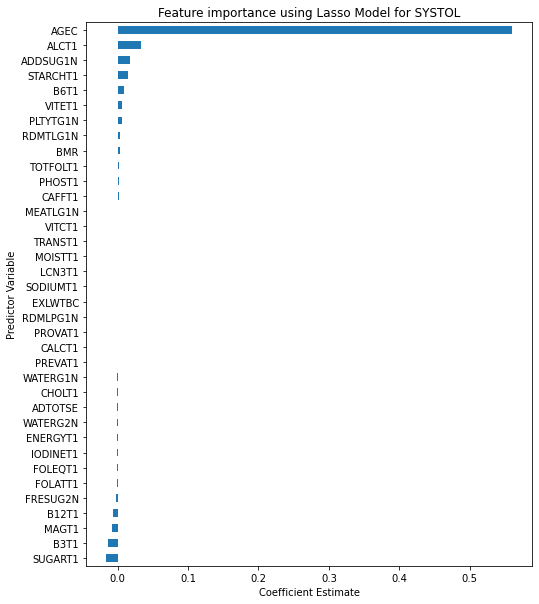

In [7]:
lasso_reg("SYSTOL")

### DIASTOL

Best alpha using built-in LassoCV: 6.833772
Best score using built-in LassoCV (R-Squared): 0.083789


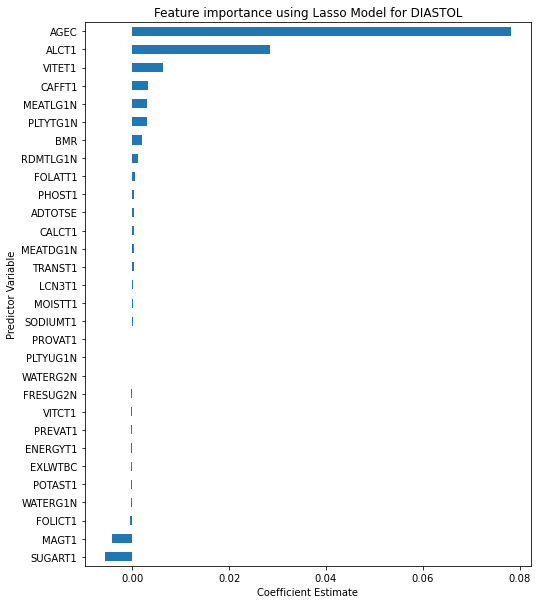

In [8]:
lasso_reg("DIASTOL")

### BMISC

Best alpha using built-in LassoCV: 3.260273
Best score using built-in LassoCV (R-Squared): 0.430774


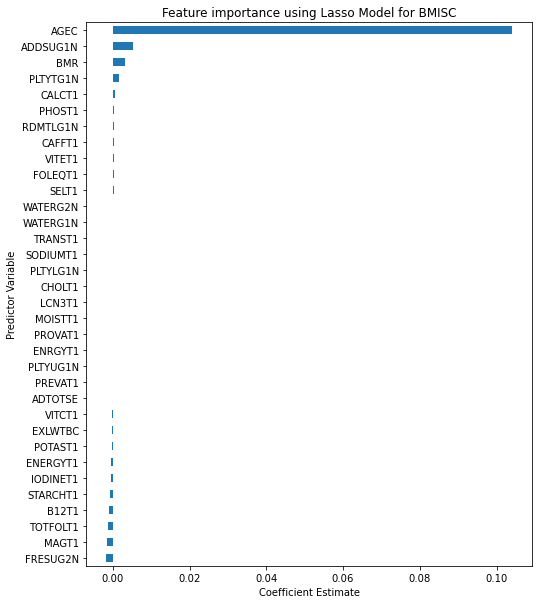

In [9]:
lasso_reg("BMISC")

### CHOLRESB

Accuracy: 0.185 (0.016)


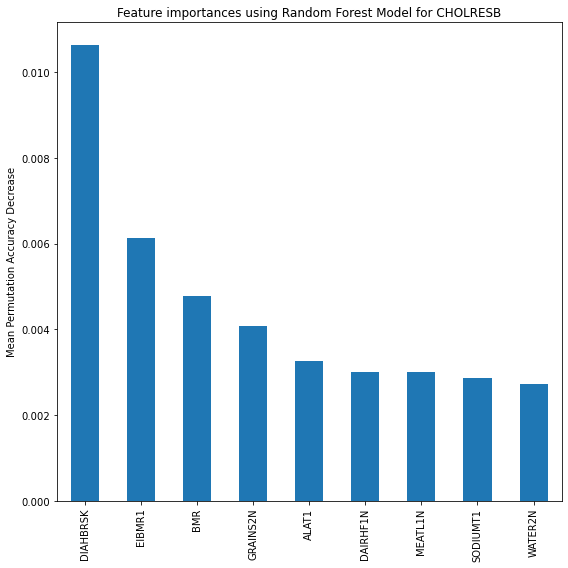

In [10]:
random_forest("CHOLRESB")

### CHOLNTR

Accuracy: 0.625 (0.021)


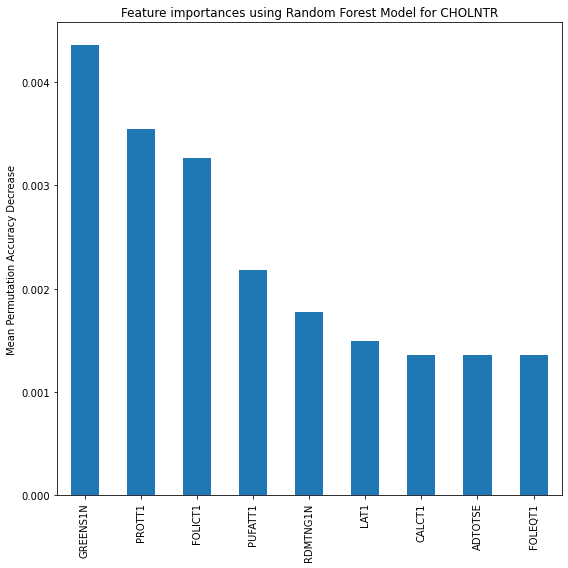

In [17]:
random_forest("CHOLNTR")

Accuracy: 0.629 (0.018)


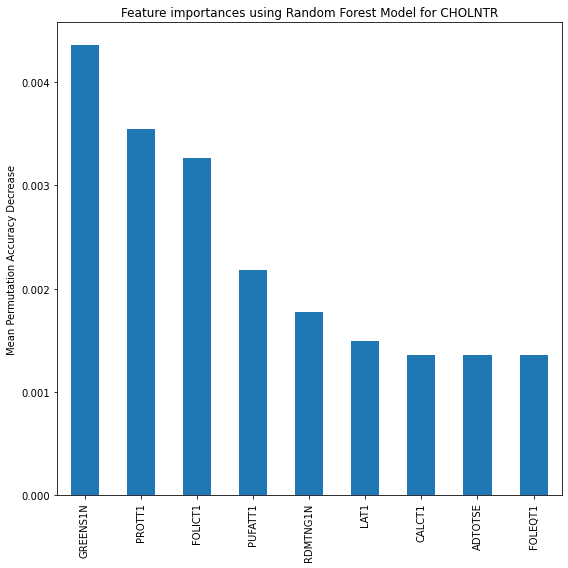

In [11]:
random_forest("CHOLNTR")

### HDLCHREB

Best alpha using built-in LassoCV: 0.568568
Best score using built-in LassoCV (R-Squared): 0.235810


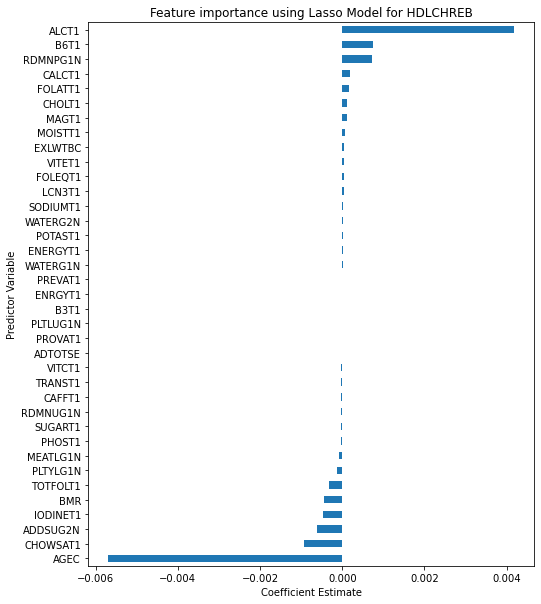

In [12]:
lasso_reg("HDLCHREB")

### LDLNTR

Accuracy: 0.642 (0.028)


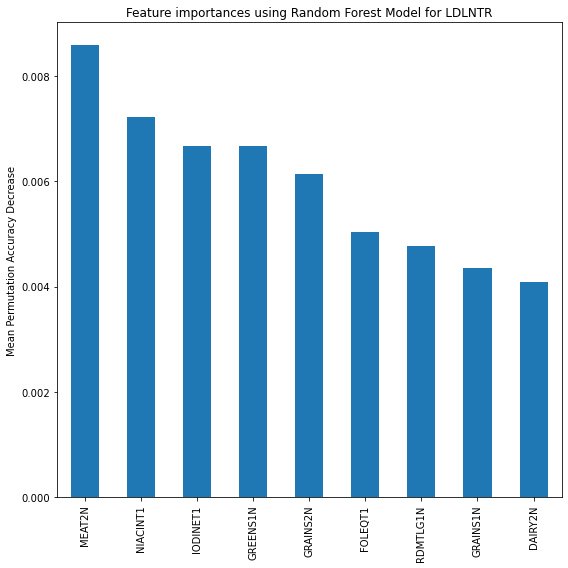

In [13]:
random_forest("LDLNTR")

### LDLRESB

Best alpha using built-in LassoCV: 0.100128
Best score using built-in LassoCV (R-Squared): 0.054176


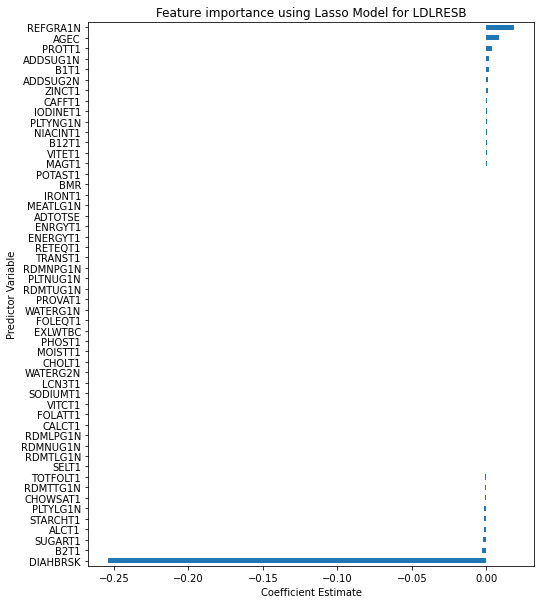

In [14]:
lasso_reg("LDLRESB")

### HSUGBC

Accuracy: 0.955 (0.015)


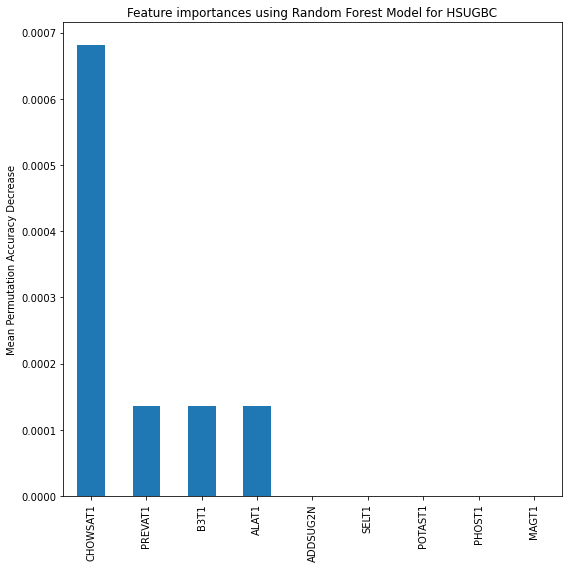

In [15]:
random_forest("HSUGBC")